In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
pwd = "/content/drive/MyDrive/ECE661FinalProj_OODD"
os.chdir(pwd)

Mounted at /content/drive


In [3]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
def swish(x):
    return x/(1+torch.exp(-x))

In [5]:
# define the Resnet20 mode;
class Resnet20(nn.Module):
    def __init__(self):
        super(Resnet20, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm0 = nn.BatchNorm2d(16)
        
        self.conv1a = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1a = nn.BatchNorm2d(16)
        self.conv1b = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1b = nn.BatchNorm2d(16)
        self.conv1c = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1c = nn.BatchNorm2d(16)
        self.conv1d = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1d = nn.BatchNorm2d(16)
        self.conv1e = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1e = nn.BatchNorm2d(16)
        self.conv1f = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1f = nn.BatchNorm2d(16)
        
        self.conv1_2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.batchnorm1_2 = nn.BatchNorm2d(32)
        self.bypass1_2 = nn.Conv2d(16, 32, 1, stride=2)
        self.conv2a = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2a = nn.BatchNorm2d(32)
        self.conv2b = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2b = nn.BatchNorm2d(32)
        self.conv2c = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2c = nn.BatchNorm2d(32)
        self.conv2d = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2d = nn.BatchNorm2d(32)
        self.conv2e = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2e = nn.BatchNorm2d(32)
        
        self.conv2_3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.batchnorm2_3 = nn.BatchNorm2d(64)
        self.bypass2_3 = nn.Conv2d(32, 64, 1, stride=2)
        self.conv3a = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3a = nn.BatchNorm2d(64)
        self.conv3b = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3b = nn.BatchNorm2d(64)
        self.conv3c = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3c = nn.BatchNorm2d(64)
        self.conv3d = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3d = nn.BatchNorm2d(64)
        self.conv3e = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3e = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        # Inital convolution
        out = self.batchnorm0(self.conv0(x))
        out = bypass = swish(out)
        # Block 1   (condense block layers into functions)
            # Layer 1
        out = self.batchnorm1a(self.conv1a(out))
        out = swish(out)
        out = self.batchnorm1b(self.conv1b(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm1c(self.conv1c(out))
        out = swish(out)
        out = self.batchnorm1d(self.conv1d(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm1e(self.conv1e(out))
        out = swish(out)
        out = self.batchnorm1f(self.conv1f(out))
        out = bypass = swish(out + bypass)
        # Block 2
            # Layer 1
        bypass = self.bypass1_2(bypass)
        out = self.batchnorm1_2(self.conv1_2(out))
        out = swish(out)
        out = self.batchnorm2a(self.conv2a(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm2b(self.conv2b(out))
        out = swish(out)
        out = self.batchnorm2c(self.conv2c(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm2d(self.conv2d(out))
        out = swish(out)
        out = self.batchnorm2e(self.conv2e(out))
        out = bypass = swish(out + bypass)
        # Block 3
            # Layer 1
        bypass = self.bypass2_3(bypass)
        out = self.batchnorm2_3(self.conv2_3(out))
        out = swish(out)
        out = self.batchnorm3a(self.conv3a(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm3b(self.conv3b(out))
        out = swish(out)
        out = self.batchnorm3c(self.conv3c(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm3d(self.conv3d(out))
        out = swish(out)
        out = self.batchnorm3e(self.conv3e(out))
        out = bypass = swish(out + bypass)
        
        # Global Average Pool to go from 8x8 -> 1x1 feature maps
        out = F.avg_pool2d(out, 8)
        
        # Fully Connected Layer
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [6]:
class OODTensorDataset:
    def __init__(self, tensor_data, transforms=None):
        self.tensors = tensor_data
        self.transforms = transforms
    
    def __getitem__(self, index):   
        x = self.tensors[index]
        if self.transforms:
            x = self.transforms(x)
        return x, -1                 # returing -1 for OOD labels
    
    def __len__(self):
        return self.tensors.size()[0]

In [7]:
# useful libraries
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10 as torchCIFAR10

#############################################
# your code here
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

rndimg_mean = (136.289, 129.273,122.668)
rndimg_std  = (73.788, 73.672, 76.487)

# specify preprocessing function
transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std),
                                     transforms.RandomCrop(size=32, padding=4),
                                     transforms.RandomHorizontalFlip()])

tensor_transform_train = transforms.Compose([transforms.Normalize(rndimg_mean, rndimg_std),
                                     transforms.RandomCrop(size=32, padding=4),
                                     transforms.RandomHorizontalFlip()])

transform_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

transform_visulaizer = transforms.Compose([transforms.ToTensor()])
#############################################

In [8]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader
import numpy as np

# a few arguments, do NOT change these
DATA_ROOT = "./data"
RANDOM_IMGS = DATA_ROOT + "/300K_random_images.npy"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100
OOD_BS = 256

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform= transform_train
)

random_images_data = torch.permute(torch.from_numpy(np.load(RANDOM_IMGS)), (0,3,1,2)).float()  
rand_img_set = OODTensorDataset(
    random_images_data,
    tensor_transform_train
)

val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform= transform_val
)
test_set = CIFAR10(
    root=DATA_ROOT,
    mode='test',
    download=True,
    transform=transform_test
)
torch_train_set = torchCIFAR10(
    root=DATA_ROOT,
    train=True,
    transform=transform_train,
    download=True
)

torch_test_set = torchCIFAR10(
    root=DATA_ROOT,
    train=False,
    transform=transform_test,
    download=True
)
torch_vis_set = torchCIFAR10(
    root=DATA_ROOT,
    train=False,
    transform=transform_visulaizer,
    download=True
)


# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size= TRAIN_BATCH_SIZE,  # your code
    shuffle= True,     # your code
    num_workers=4
)

train_loader_in = DataLoader(
    torch_train_set, 
    batch_size= TRAIN_BATCH_SIZE,  # your code
    shuffle = True
)

train_loader_ood = DataLoader(
    rand_img_set,
    batch_size = OOD_BS,
    shuffle = True
)

val_loader = DataLoader(
    torch_test_set, 
    batch_size= VAL_BATCH_SIZE,  # your code
    shuffle= False,     # your code
    # num_workers=4
)
test_loader = DataLoader(
    test_set,
    batch_size = 100,
    shuffle = False,
    num_workers=4
)
torch_test_loader = DataLoader(
    torch_test_set
)
torch_visualizer_loader = DataLoader(
    torch_vis_set
)
#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_test_F22.zip
Extracting ./data/cifar10_test_F22.zip to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#TRAINING

In [10]:
def energy_fun(cnn_output, T):
  return -T* torch.logsumexp(cnn_output / T, dim=1)

In [11]:
from torch.cuda.random import device_count
# specify the device for computation
#############################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
cnn = Resnet20()
cnn.to(device)
#############################################

cuda:0


Resnet20(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1a): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1a): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1c): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1c): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1d): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1d): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1e): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1e): BatchNorm2d(16, eps=1e-

In [15]:
import torch.nn as nn
import torch.optim as optim

WARMUP_LR = .01
MOMENTUM = 0.9
REG = 5e-4
optimizer = optim.SGD(cnn.parameters(), lr=WARMUP_LR, momentum=MOMENTUM, weight_decay=REG)

EPOCHS = 150
CHECKPOINT_FOLDER = "./saved_model"
INITAL_LR = .1
DECAY_EPOCHS = 60
DECAY = .1
m_in = -23
m_out = -5

In [20]:
def train():
    avg_loss = 0
    best_val_acc = 0
    current_learning_rate = WARMUP_LR
    train_loader_ood.dataset.offset = np.random.randint(len(train_loader_ood.dataset))
    #Learning rate scheduler
    for i in tqdm(range(EPOCHS)):
        if i == 5:
            current_learning_rate = INITAL_LR
        if i % DECAY_EPOCHS == 0 and i != 0:
            current_learning_rate = current_learning_rate * DECAY
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_learning_rate
            #print("Current learning rate has decayed to %f" %current_learning_rate)
    
        cnn.train()
        
        print(f"Epoch: {i}/{EPOCHS}")
        for in_set, out_set in zip(train_loader_in, train_loader_ood):
            
            data = torch.cat((in_set[0], out_set[0]), 0)
            target = in_set[1].type(torch.LongTensor)
            data, target = data.to(device), target.to(device)
            
            # Forward Pass
            x = cnn.forward(data)
            
            loss = F.cross_entropy(x[:len(in_set[0])], target)
            # cross-entropy from softmax distribution to uniform distribution
            # loss += 0.5 * -(x[len(in_set[0]):].mean(1) - torch.logsumexp(x[len(in_set[0]):], dim=1)).mean()
            
            Ec_out = -torch.logsumexp(x[len(in_set[0]):], dim=1)
            Ec_in = -torch.logsumexp(x[:len(in_set[0])], dim=1)
            loss += 0.1*(torch.pow(F.relu(Ec_in- m_in), 2).mean() + torch.pow(F.relu(m_out-Ec_out), 2).mean())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_loss = .8 * avg_loss + float(loss) * 0.2
       
        print(f"avg training loss: {avg_loss}")
        
        
        cnn.eval()

        total_examples = 0
        correct_examples = 0

        val_loss = 0

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
              if batch_idx < 0.25*len(val_loader):
                # copy inputs to device
                inputs = inputs.to(device)
                targets = targets.type(torch.LongTensor)
                targets = targets.to(device)

                # compute the output and loss
                output = cnn.forward(inputs)
                loss = F.cross_entropy(output, targets)
                val_loss += loss

                # count the number of correctly predicted samples in the current batch
                total_examples += targets.size()[0]
                batch_preds = torch.argmax(output, dim=1)
                correct_examples += (batch_preds == targets).int().sum().item()

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
        
        #save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
               os.makedirs(CHECKPOINT_FOLDER)
            print("Saving ...")
            state = {'state_dict': cnn.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'ENERGY_OE_resnet20.pth'))

    
train()

<ipython-input-20-4b617f57facc>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(EPOCHS)):


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 0/150
avg training loss: 2.6827409571120078
Validation loss: 0.3807, Validation accuracy: 0.4444
Saving ...
Epoch: 1/150
avg training loss: 2.8623621463775635
Validation loss: 0.3800, Validation accuracy: 0.4364
Epoch: 2/150
avg training loss: 2.698941230773926
Validation loss: 0.3509, Validation accuracy: 0.4824
Saving ...
Epoch: 3/150
avg training loss: 2.551147937774658
Validation loss: 0.3383, Validation accuracy: 0.5116
Saving ...
Epoch: 4/150
avg training loss: 2.643597364425659
Validation loss: 0.3100, Validation accuracy: 0.5472
Saving ...
Epoch: 5/150
avg training loss: 2.3866798877716064
Validation loss: 0.3143, Validation accuracy: 0.5432
Epoch: 6/150
avg training loss: 2.1905810832977295
Validation loss: 0.2966, Validation accuracy: 0.5736
Saving ...
Epoch: 7/150
avg training loss: 2.1294641494750977
Validation loss: 0.2936, Validation accuracy: 0.5780
Saving ...
Epoch: 8/150
avg training loss: 1.8574376106262207
Validation loss: 0.2918, Validation accuracy: 0.5920
S

#TESTING

In [12]:
cnn = Resnet20().to(device)
cnn.load_state_dict(torch.load("./saved_model/ENERGY_OE_resnet20.pth")["state_dict"])
cnn.eval()

Resnet20(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1a): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1a): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1c): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1c): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1d): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1d): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1e): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1e): BatchNorm2d(16, eps=1e-

In [13]:
total_examples = 0
correct_examples = 0
val_loss = 0 
corr_score = []
fals_score = []
T = 1
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
      if batch_idx > 0.25*len(val_loader):
          # copy inputs to device
          inputs = inputs.to(device)
          targets = targets.type(torch.LongTensor)
          targets = targets.to(device)
          # compute the output and loss
          output = cnn.forward(inputs)
          softmax = F.softmax(output, dim=1)
          energy = energy_fun(output, T)

          # count the number of correctly predicted samples in the current batch
          total_examples += targets.size()[0]
          batch_preds = torch.argmax(output, dim=1)
          correct_mask = (batch_preds == targets)
          correct_examples += correct_mask.int().sum().item()
          soft_batch_preds = torch.argmax(softmax, dim=1)
          for i in range(len(correct_mask)):
              if correct_mask[i]:
                  corr_score.append(energy[i].item())
              else:
                  fals_score.append(energy[i].item())

print(fals_score)
print(corr_score)
print(correct_examples/total_examples)
InD_score = fals_score + corr_score

[-29.28626823425293, -8.531516075134277, -4.467621803283691, -33.45845031738281, -27.87527084350586, -38.314109802246094, -31.624277114868164, -33.451698303222656, -34.10587692260742, -34.02817916870117, -31.019338607788086, -29.613309860229492, -33.401756286621094, -30.974748611450195, -31.83510971069336, -30.076820373535156, -29.616134643554688, -33.41300582885742, -37.85172653198242, -28.870058059692383, -27.395347595214844, -33.7912483215332, -36.879695892333984, -30.877885818481445, -35.690914154052734, -24.756067276000977, -27.063720703125, -22.82866096496582, -34.27249526977539, -27.36802101135254, -22.34912109375, -26.436128616333008, -28.49004554748535, -23.279443740844727, -27.397886276245117, -30.00636100769043, -34.14260482788086, -29.165000915527344, -24.24211883544922, -35.138153076171875, -29.220083236694336, -32.90825653076172, -35.964256286621094, -30.130943298339844, -29.18241310119629, -31.626832962036133, -29.14476776123047, -31.319643020629883, -42.52009582519531, 

In [26]:
import numpy as np
# true positive here is defined as correctly classifying a prediction as erroneous
def plot_roc(false_softs, true_softs, title = "ROC Curve", show_95TPR = True, show_OPT = False):
    TPRs = []     #  true positive rates
    FPRs = []     # false positive rates
    AUROC = []    # will contain the AUROC approximation segments
    opt = {"thresh":-1, "diff":-1, "FPR":-1, "TPR":-1}
    FPR_at_TPR95 = -1
    closest_TPR_to95 = -1
    prev_FPR = 0
    ct95 = 1
    min_val = min(min(false_softs), min(true_softs))
    max_val = max(max(false_softs), max(true_softs))
    for i in tqdm(np.linspace(min_val, max_val, 1000)):
        FPR = sum(false_softs < i)/len(false_softs)
        TPR = sum(true_softs < i)/len(true_softs)
        AUROC.append((FPR-prev_FPR)*TPR)
        prev_FPR = FPR
        dis_from_95 = .95-TPR
        if abs(dis_from_95) < ct95:
            ct95 = dis_from_95
            FPR_at_TPR95 = FPR
            closest_TPR_to95 = TPR
        # if round(TPR,2) == .95:
        #     FPR_at_TPR95 = FPR
        TPRs.append(TPR)
        FPRs.append(FPR)
        if TPR-FPR > opt["diff"]:
            opt["thresh"], opt["diff"], opt["FPR"], opt["TPR"]  = i, TPR-FPR, FPR, TPR
    plt.plot(FPRs, TPRs, 'm')
    plt.plot([0,1], [0,1], "k--", linewidth=.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    if show_95TPR:
        plt.plot(FPR_at_TPR95, closest_TPR_to95, 'X', ms=11, label=f"FPR@95TPR: {round(FPR_at_TPR95,3)}")
    if show_OPT:
        plt.plot(opt["FPR"], opt["TPR"], 'X', ms=11, label=f"OPT Thresh: {round(opt['thresh'],3)}")
        print(opt)
    plt.legend()
    plt.show()
    print(closest_TPR_to95)
    print(f"AUROC: {sum(AUROC)}")

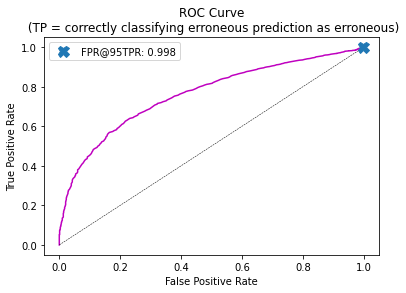

AUROC: 0.7631873012525145


In [16]:
plot_roc(fals_score, corr_score, title="ROC Curve\n (TP = correctly classifying erroneous prediction as erroneous)")

In [15]:
from torchvision.datasets import CIFAR100

cifar100_set = CIFAR100(
    root=DATA_ROOT,
    train=False,
    transform=transform_test,
    download=True
)

cifar100_loader = DataLoader(
    cifar100_set
)

Files already downloaded and verified


In [18]:
def find_OOD_score(OOD_loader):
  OOD_score = []
  with torch.no_grad():
      for i, (img, target) in tqdm(enumerate(OOD_loader)):
          img = img.to(device)
          target = target.type(torch.LongTensor)
          target = target.to(device)

          output = cnn.forward(img)
          energy = energy_fun(output, T)
          softmax = F.softmax(output, dim=1)
          # print(softmax.shape)
          OOD_score.append(energy.item())
          batch_pred = torch.argmax(output, dim=1)
  return OOD_score

<ipython-input-26-548e302c152f>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.linspace(min_val, max_val, 1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

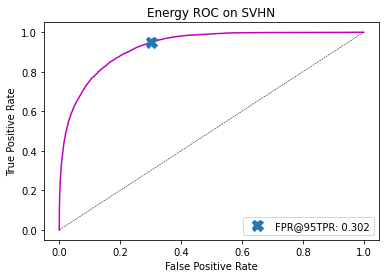

0.9505405405405405
AUROC: 0.9280756455706295


In [29]:
plot_roc(OOD_score, InD_score, title="Energy ROC on SVHN")

In [2]:
from torchvision.datasets import SVHN

SVHN_OOD_Data = SVHN(
    root='./data/ ',
    transform=transform_test,
    download=True
)
SVHN_OOD_loader = DataLoader(
    SVHN_OOD_Data
)

NameError: ignored

In [20]:
svhn_nrgOOD_score = find_OOD_scores(SVHN_OOD_loader)

<ipython-input-18-8025a2e3d1f0>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (img, target) in tqdm(enumerate(OOD_loader)):


0it [00:00, ?it/s]